<a href="https://colab.research.google.com/github/Riky2014/NAPDE/blob/main/cerchi_sensitivity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install

In [1]:
%%capture

!pip install -U "monai-weekly[fire, nibabel, yaml, tqdm, einops]"
!pip install GPUtil
from GPUtil import showUtilization as gpu_usage
gpu_usage()

# Mount Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import and set directory

In [6]:
import os
import shutil
import tempfile
import time
import matplotlib.pyplot as plt
import monai
import numpy as np
from glob import glob
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader, decollate_batch
from monai.handlers.utils import from_engine
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.networks.nets import SegResNet
from monai.transforms import (
    Activations,
    Activationsd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    Invertd,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    EnsureTyped,
    EnsureChannelFirstd,
)
from monai.utils import set_determinism
from nibabel import load, save, Nifti1Image

import torch
import logging
import sys
from PIL import Image
from torch.utils.tensorboard import SummaryWriter
from monai.data import create_test_image_2d, list_data_collate, decollate_batch, DataLoader
from monai.visualize import plot_2d_or_3d_image

os.environ["MONAI_DATA_DIRECTORY"] = "/content/drive/MyDrive/prova_cerchi_dir"
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory

# Sensitivity - training set dimention

In [8]:
n_train_vec  = [10, 20, 40, 80, 160, 320]
n_test = 40

max_epochs = 50

metric_values_vec = []
metric_values_train_vec = []

for n_train in n_train_vec:

  print(f"Number of training images = {n_train}")
  print(f"Number of testing images = {n_test}")
  print()

  for i in range(n_train + n_test):
    image, label = create_test_image_2d(128, 128, num_seg_classes = 1, noise_max = 0.0)
    Image.fromarray((image * 255).astype("uint8")).save(os.path.join(root_dir, f"image{i:d}.png"))
    Image.fromarray((label * 255).astype("uint8")).save(os.path.join(root_dir, f"label{i:d}.png"))

  set_determinism(seed=0)

  images = sorted(glob(os.path.join(root_dir, "image*.png")))
  labels = sorted(glob(os.path.join(root_dir, "label*.png")))
  train_files = [{"image": image, "label": label} for image, label in zip(images[:n_train], labels[:n_train])]
  val_files = [{"image": image, "label": label} for image, label in zip(images[-n_test:], labels[-n_test:])]

  train_transform = Compose(
  [
      LoadImaged(keys=["image", "label"]),
      EnsureChannelFirstd(keys=["image","label"]),
      EnsureTyped(keys=["image", "label"]),
      Orientationd(keys=["image", "label"], axcodes="RA"),
      Spacingd(
          keys=["image", "label"],
          pixdim=(1.0, 1.0),
          mode=("bilinear", "nearest"),
      ),
      RandSpatialCropd(keys=["image", "label"], roi_size=[128, 128], random_size=False),
      RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
      RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
      NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
      NormalizeIntensityd(keys="label", divisor= 255.0),
      RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
      RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
  ]
  )

  val_transform = Compose(
  [
      LoadImaged(keys=["image", "label"]),
      EnsureChannelFirstd(keys=["image","label"]),
      EnsureTyped(keys=["image", "label"]),
      Orientationd(keys=["image", "label"], axcodes="RA"),
      Spacingd(
          keys=["image", "label"],
          pixdim=(1.0, 1.0),
          mode=("bilinear", "nearest"),
      ),
      NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
      NormalizeIntensityd(keys="label", divisor= 255.0),
  ]
  )

  train_ds = monai.data.Dataset(data=train_files, transform=train_transform)
  train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=2)

  val_ds = monai.data.Dataset(data=val_files, transform=val_transform)
  val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=2)


  # CHOOSE MAX EPOCHS

  val_interval = 1
  VAL_AMP = True

  # standard PyTorch program style: create SegResNet, DiceLoss and Adam optimizer
  device = torch.device("cuda:0")
  model = SegResNet(
    spatial_dims = 2,
    blocks_down=[1, 2, 2, 4],
    blocks_up=[1, 1, 1],
    init_filters=16,
    in_channels=1,
    out_channels=1,
    dropout_prob=0.2,
  ).to(device)
  loss_function = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True)
  optimizer = torch.optim.Adam(model.parameters(), 1e-3, weight_decay=1e-7)
  lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

  dice_metric = DiceMetric(include_background=True, reduction="mean")
  dice_metric_train = DiceMetric(include_background=False, reduction="mean")

  post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])

  # define the inference method
  def inference(input):
      def _compute(input):
          return sliding_window_inference(
              inputs=input,
              roi_size=(128, 128),
              sw_batch_size=1,
              predictor=model,
              overlap=0.5,
          )

      if VAL_AMP:
          with torch.cuda.amp.autocast():
              return _compute(input)
      else:
          return _compute(input)

  # use "amp" to accelerate training
  scaler = torch.cuda.amp.GradScaler()
  # enable "cuDNN benchmark"
  torch.backends.cudnn.benchmark = True


  best_metric = -1
  best_metric_epoch = -1
  best_metrics_epochs_and_time = [[], [], []]
  epoch_loss_values = []
  metric_values = []
  metric_values_train = []

  total_start = time.time()

  for epoch in range(max_epochs):
    epoch_start = time.time()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step_start = time.time()
        step += 1
        inputs, labels = ( batch_data["image"].to(device), batch_data["label"].to(device) )
        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = loss_function(outputs, labels)

        outputs = [post_trans(i) for i in decollate_batch(outputs)]
        labels = [post_trans(i) for i in decollate_batch(labels)]
        dice_metric_train(y_pred=outputs, y=labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()

    metric_train = dice_metric_train.aggregate().item()
    metric_values_train.append(metric_train)
    dice_metric_train.reset()

    lr_scheduler.step()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}"
          f"\ncurrent mean train dice: {metric_train:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )

                val_outputs = inference(val_inputs)
                val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_trans(i) for i in decollate_batch(val_labels)]

                dice_metric(y_pred=val_outputs, y=val_labels)

            metric = dice_metric.aggregate().item()
            metric_values.append(metric)
            dice_metric.reset()

            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                best_metrics_epochs_and_time[0].append(best_metric)
                best_metrics_epochs_and_time[1].append(best_metric_epoch)
                best_metrics_epochs_and_time[2].append(time.time() - total_start)
                torch.save(
                    model.state_dict(),
                    os.path.join(root_dir, "best_metric_model.pth"),
                )
                #print("saved new best metric model")
            """
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}")
            """

    print(f"time consuming of epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}")
    total_time = time.time() - total_start
  print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}, total time: {total_time}.")

  metric_values_train_vec.append(metric_values_train[-1])
  metric_values_vec.append(metric_values[-1])
  print()
  print(f"Train metric = {metric_values_train[-1]}, Test metric = {metric_values[-1]}")
  print()
  print()

Number of training images = 10
Number of testing images = 40

----------
epoch 1/50
epoch 1 average loss: 0.7517
current mean train dice: 0.7428
time consuming of epoch 1 is: 5.8934
----------
epoch 2/50
epoch 2 average loss: 0.5885
current mean train dice: 0.8611
time consuming of epoch 2 is: 3.1307
----------
epoch 3/50
epoch 3 average loss: 0.5081
current mean train dice: 0.9059
time consuming of epoch 3 is: 3.1618
----------
epoch 4/50
epoch 4 average loss: 0.4586
current mean train dice: 0.9392
time consuming of epoch 4 is: 4.5047
----------
epoch 5/50
epoch 5 average loss: 0.4261
current mean train dice: 0.9422
time consuming of epoch 5 is: 3.2894
----------
epoch 6/50
epoch 6 average loss: 0.4006
current mean train dice: 0.9549
time consuming of epoch 6 is: 3.3221
----------
epoch 7/50
epoch 7 average loss: 0.3788
current mean train dice: 0.9585
time consuming of epoch 7 is: 3.3910
----------
epoch 8/50
epoch 8 average loss: 0.3670
current mean train dice: 0.9597
time consuming 

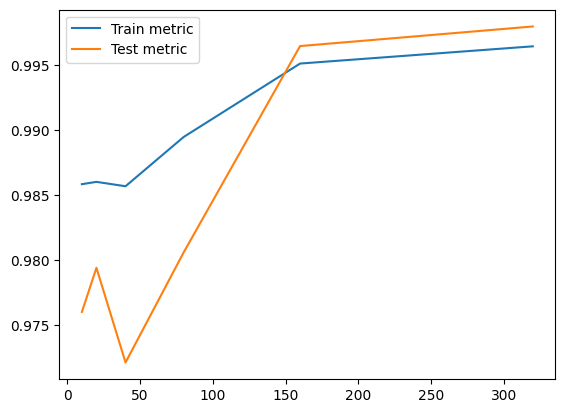

In [9]:
plt.subplots()
plt.plot(n_train_vec, metric_values_train_vec, label = 'Train metric')
plt.plot(n_train_vec, metric_values_vec, label = 'Test metric')
plt.legend()